In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [2]:
import plotly.figure_factory as ff

# Example: Wind Damaged Trees 

In 1999, a huge storm with winds over 90 mph damaged millions of trees in the [Boundary Waters Canoe Area Wilderness](https://www.fs.usda.gov/detail/superior/specialplaces/?cid=fseprd555184) (BWCAW), which has the largest tract of virgin forest in the eastern US. In an effort to understand the susceptibility of trees to wind damage, a researcher named [Roy Lawrence Rich](https://www.proquest.com/docview/305463532?pq-origsite=gscholar&fromopenview=true) carried out a ground survey of the BWCAW. In the years following this study, other researchers have used this dataset to model windthrow--the uprooting of trees in strong winds.

The population under study are the trees in the BWCAW. The access frame are *transects*: straight lines that cut through the natural landscape. These particular transects begin close to a lake and travel orthogonal to the gradient of the land for 250-400 meters. Along these transects, surveyors stop every 25 meters and examine a 5x5 meter plot. At each plot, trees were counted, categorized as blown-down or standing, measured in diameter at 6 ft from the ground, and their species recorded. 

Sampling protocols like this are common for studying natural resources. In the BWCAW, over 80% of the land in the region is within 500 meters of a lake so the access frame nearly covers the population. The study took place over the summers of  2000 and 2001, and no other natural disasters happened between the 1999 storm and when the data were collected. 

Measurements were collected on over 3600 trees, but in this example, we examine just the black spruce. There are over 650 of them. We read these data in:

In [3]:
trees = pd.read_csv('data/black_spruce.csv')
trees

,diameter,storm,status
0,9.0,0.02,standing
1,11.0,0.03,standing
2,9.0,0.03,standing
...,...,...,...
656,9.0,0.94,fallen
657,17.0,0.94,fallen
658,8.0,0.98,fallen


Each row corresponds to a single tree, and has the following attributes:

- `diameter`: Diameter of the tree in cm, measured at 6 ft above the ground. 
- `storm`: Severity of the storm (fraction of trees that fell in a 25 meter-wide area containing the tree).
- `status`: Tree has "fallen" or is "standing".

Let's begin with some exploratory analysis before we turn to modeling. First, we calculate some simple summary statistics:

In [153]:
trees.describe()[3:]

,diameter,storm
min,5.0,0.02
25%,6.0,0.21
50%,8.0,0.36
75%,12.0,0.55
max,32.0,0.98


Based on the quartiles, the distribution of tree diameter seems skewed right. Let's compare  the distribution of diameter for the standing and fallen trees with histograms:

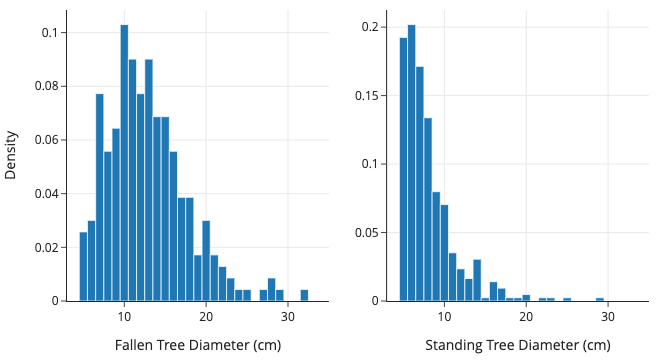

In [154]:
f1 = px.histogram(trees.query('status == "fallen"'), x="diameter", 
                  histnorm='probability density', nbins = 30)
f2 = px.histogram(trees.query('status == "standing"'), x="diameter", 
                  histnorm='probability density')

fig = left_right(f1, f2, height=250, width=600)
fig.update_xaxes(title_text='Fallen Tree Diameter (cm)', 
                 row=1, col=1, range=[3, 35])
fig.update_xaxes(title_text='Standing Tree Diameter (cm)', 
                 row=1, col=2, range=[3, 35])
fig.update_yaxes(title_text='Density', row=1, col=1)
fig.show()

The distribution of the diameter of the trees that fell in the storm is centered at 12 cm with a right skew. In comparison, the standing trees were nearly all under 10 cm in diameter with a mode at about 6 cm (only trees with a diameter of at least 5 cm are included in the study). 

Another feature to investigate is the strength of the storm, and we plot the storm strength against tree diameter using the symbol and marker color to distinguish the standing trees from the fallen. Since the diameter is essentially measured to the nearest cm, many trees have the same diameter, so we jitter the values by adding a bit of noise to the diameter values to help reduce over plotting (see {numref}`Chapter %s <ch:viz>`). We also adjust the opacity of the marker colors to reveal the denser regions on the plot: 

In [155]:
def jitter(data, amt=0.2):
    return data + amt * (np.random.rand(len(data)) - 0.5)

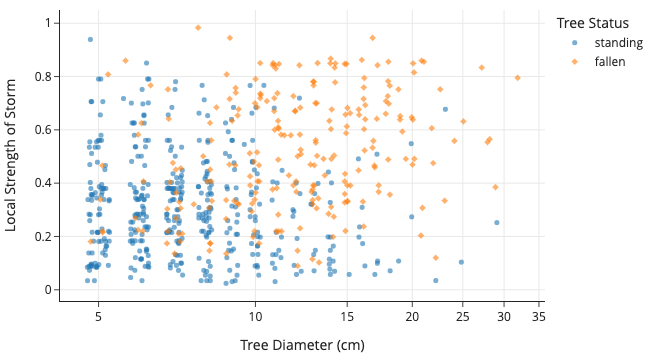

In [157]:
fig = px.scatter(
    trees, x=jitter(trees["diameter"], amt=0.5), y="storm",
    color="status", symbol="status",
    log_x=True, width=650, height=300,
)

fig.update_traces(marker=dict(opacity=0.6, size=5))

fig.update_layout(
    xaxis_title="Tree Diameter (cm)",
    yaxis_title="Local Strength of Storm",
    legend_title="Tree Status",
)

fig

From this plot, it looks like both the tree diameter and the strength of the storm are related to windthrow: whether the tree was uprooted or left standing. Notice that windthrow, the feature we want to predict, is a nominal variable. In the next section, we consider how this impacts the prediction problem.